In [ ]:
!pip install numba

# Iniciar

## Importações

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Resizing
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from numba import cuda

import gc

from PIL import Image

In [ ]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
cifar10 = keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [ ]:
#train_images = tf.image.resize(train_images, (224, 224))
#test_images = tf.image.resize(test_images, (224, 224))
#train_images = train_images [:300]
#train_labels = train_labels [:300]
#test_images = test_images [:300]
#test_labels = test_labels [:300]

In [ ]:
len(train_images)

50000

In [ ]:
len(test_images)

10000

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

#train_labels = to_categorical(train_labels)
#test_labels = to_categorical(test_labels)

In [ ]:
list_learn_rate = [1e-2,1e-3,1e-4]
list_batch_size = [128,256,512]
list_epochs = [10,20,30]

## Definindo modelos

AlexNet https://pt.d2l.ai/chapter_convolutional-modern/alexnet.html

In [ ]:
def create_alexnet(num_classes=10, batch_normalization = False, dropout = False):
  # Definindo a arquitetura da AlexNet
  model = tf.keras.models.Sequential()

  # Adicionando as camadas convolucionais
  model.add(tf.keras.layers.Resizing(224, 224, input_shape=(None, None, 3)))
  model.add(tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), padding='valid'))
  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

  model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same'))
  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

  model.add(tf.keras.layers.Conv2D(384, (3, 3), padding='same'))
  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))

  model.add(tf.keras.layers.Conv2D(384, (3, 3), padding='same'))
  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))

  model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same'))
  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

  # Flatten para as camadas totalmente conectadas
  model.add(tf.keras.layers.Flatten())

  # Adicionando as camadas totalmente conectadas
  model.add(tf.keras.layers.Dense(4096))
  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  if dropout:
    model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(4096))
  if batch_normalization:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  if dropout:
    model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
  return model  # Número de classes para classificação
  """
    model_alex = Sequential([
        Resizing(224, 224, input_shape=(None, None, 3)),  # Add Resizing layer
        Conv2D(96, (11, 11), strides=(4, 4), activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(nodes, activation='softmax')
    ])
      return model_alex
    """





In [ ]:
#cifar_model_alexnet = create_alexnet(10)
#cifar_model_alexnet.summary()

In [ ]:
def create_vgg16(num_classes=10, batch_normalization = False, dropout = False):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Resizing(224, 224, input_shape=(None, None, 3)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Bloco 2
    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Bloco 3
    model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Bloco 4
    model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Bloco 5
    model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same'))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Camada densa
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    if dropout:
      model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096))
    if batch_normalization:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    if dropout:
      model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    return model

In [ ]:
#cifar_model_vgg16 = create_vgg16()
#cifar_model_vgg16.summary()


# Testes Ciphar AlexNet

##AlexNet Parte 1

In [ ]:
learn_rate_history = []
learn_rate_history_test = []
for learn_rate in list_learn_rate:
  cifar_model_alexnet = create_alexnet()
  cifar_model_alexnet.compile(optimizer=SGD(learning_rate=learn_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  learn_rate_history.append(cifar_model_alexnet.fit(train_images, train_labels, batch_size=256, epochs=20))
  learn_rate_history_test = cifar_model_alexnet.evaluate(test_images,  test_labels, batch_size=256, verbose=5)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


196/196 [==============================] - 51s 195ms/step - loss: 2.2576 - accuracy: 0.1571
Epoch 2/20
196/196 [==============================] - 37s 188ms/step - loss: 2.0935 - accuracy: 0.2422
Epoch 3/20
196/196 [==============================] - 36s 182ms/step - loss: 1.9488 - accuracy: 0.2989
Epoch 4/20
196/196 [==============================] - 37s 187ms/step - loss: 1.8166 - accuracy: 0.3493
Epoch 5/20
196/196 [==============================] - 36s 185ms/step - loss: 1.6969 - accuracy: 0.3975
Epoch 6/20
196/196 [==============================] - 36s 185ms/step - loss: 1.5965 - accuracy: 0.4346
Epoch 7/20
196/196 [==============================] - 37s 187ms/step - loss: 1.5024 - accuracy: 0.4672
Epoch 8/20
196/196 [==============================] - 37s 186ms/step - loss: 1.4379 - accuracy: 0.4910
Epoch 9/20
196/196 [==============================] - 37s 186ms/step - loss: 1.3719 - accuracy: 0.5142
Epoch 10/20
196/196 [==============================] - 37s 187ms/step - loss: 1.3246

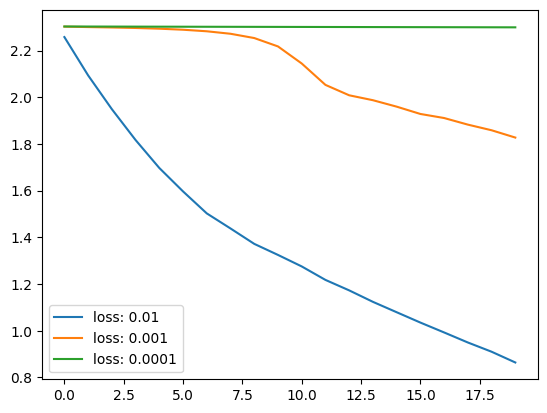

In [ ]:
import matplotlib.pyplot as plt

for i in range (len(learn_rate_history)):
  plt.plot(learn_rate_history[i].history["loss"],label=f'loss: {list_learn_rate[i]}')
  plt.legend()



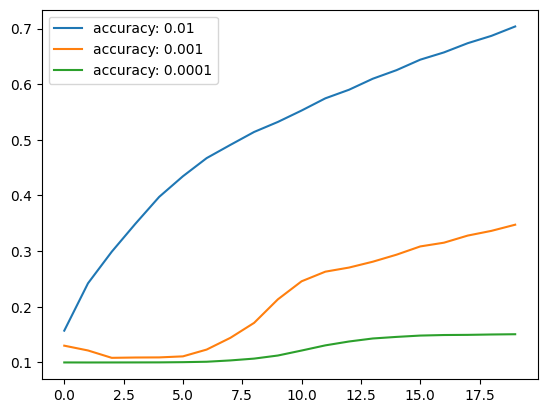

In [ ]:
for i in range (len(learn_rate_history)):
  plt.plot(learn_rate_history[i].history["accuracy"],label=f'accuracy: {list_learn_rate[i]}')
  plt.legend()

In [ ]:
accuracies = [history.history["accuracy"] for history in learn_rate_history]
best_accuracy_index = max(range(len(accuracies)), key=lambda i: accuracies[i][-1])
best_learn_rate_for_accuracy = list_learn_rate[best_accuracy_index]

print(f"Melhor taxa de aprendizado para a maior accuracy: {best_learn_rate_for_accuracy}")


Melhor taxa de aprendizado para a maior accuracy: 0.01


In [ ]:
history_batchsize = []
history_test_batchsize = []
best_accuracy = 0
best_batch_size = None
contador = 0

for batch_size in list_batch_size:
  cifar_model_alexnet = create_alexnet(10)
  cifar_model_alexnet.compile(optimizer=SGD(learning_rate=best_learn_rate_for_accuracy),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  history_batchsize.append(cifar_model_alexnet.fit(train_images, train_labels, batch_size=batch_size, epochs=20))
  history_test_batchsize.append(cifar_model_alexnet.evaluate(test_images,  test_labels, batch_size=batch_size, verbose=5))

  test_accuracy = history_test_batchsize[contador][1]

  contador = contador + 1
  if test_accuracy > best_accuracy:
      best_accuracy = test_accuracy
      best_batch_size = batch_size


Epoch 1/20
391/391 [==============================] - 43s 99ms/step - loss: 2.1887 - accuracy: 0.1894
Epoch 2/20
391/391 [==============================] - 38s 96ms/step - loss: 1.8706 - accuracy: 0.3294
Epoch 3/20
391/391 [==============================] - 38s 97ms/step - loss: 1.6138 - accuracy: 0.4263
Epoch 4/20
391/391 [==============================] - 38s 97ms/step - loss: 1.4631 - accuracy: 0.4805
Epoch 5/20
391/391 [==============================] - 38s 97ms/step - loss: 1.3605 - accuracy: 0.5196
Epoch 6/20
391/391 [==============================] - 38s 97ms/step - loss: 1.2756 - accuracy: 0.5507
Epoch 7/20
391/391 [==============================] - 38s 98ms/step - loss: 1.1962 - accuracy: 0.5830
Epoch 8/20
391/391 [==============================] - 38s 98ms/step - loss: 1.1179 - accuracy: 0.6088
Epoch 9/20
391/391 [==============================] - 38s 98ms/step - loss: 1.0400 - accuracy: 0.6392
Epoch 10/20
391/391 [==============================] - 38s 97ms/step - loss: 0.972

In [ ]:
print(f"Melhor batchsize para a maior accuracy: {best_batch_size}")

Melhor batchsize para a maior accuracy: 128


## AlexNet parte 2

In [ ]:
best_learn_rate_for_accuracy = 0.01
best_batch_size = 128

In [ ]:
epochs_history = []
epochs_history_test = []

best_accuracy = 0
best_epochs = None
contador = 0

for epoch in list_epochs:
  cifar_model_alexnet = create_alexnet(10)
  cifar_model_alexnet.compile(optimizer=SGD(learning_rate=best_learn_rate_for_accuracy),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  epochs_history.append(cifar_model_alexnet.fit(train_images, train_labels, batch_size=best_batch_size, epochs=epoch))
  epochs_history_test.append(cifar_model_alexnet.evaluate(test_images,  test_labels, batch_size=10, verbose=5))

  test_accuracy = epochs_history_test[contador][1]

  contador = contador + 1

  if test_accuracy > best_accuracy:
    best_accuracy = test_accuracy
    best_epochs = epoch

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


391/391 [==============================] - 50s 93ms/step - loss: 2.1982 - accuracy: 0.1826
Epoch 2/10
391/391 [==============================] - 35s 90ms/step - loss: 1.9236 - accuracy: 0.3084
Epoch 3/10
391/391 [==============================] - 36s 91ms/step - loss: 1.6859 - accuracy: 0.3988
Epoch 4/10
391/391 [==============================] - 37s 94ms/step - loss: 1.5213 - accuracy: 0.4599
Epoch 5/10
391/391 [==============================] - 36s 93ms/step - loss: 1.4033 - accuracy: 0.5025
Epoch 6/10
391/391 [==============================] - 36s 93ms/step - loss: 1.3125 - accuracy: 0.5371
Epoch 7/10
391/391 [==============================] - 37s 94ms/step - loss: 1.2278 - accuracy: 0.5671
Epoch 8/10
391/391 [==============================] - 37s 94ms/step - loss: 1.1485 - accuracy: 0.5981
Epoch 9/10
391/391 [==============================] - 37s 94ms/step - loss: 1.0698 - accuracy: 0.6311
Epoch 10/10
391/391 [==============================] - 37s 94ms/step - loss: 0.9940 - accurac

In [ ]:
print(f"Melhor epochs para a maior accuracy: {best_epochs}")

Melhor epochs para a maior accuracy: 30


## Parte 3

In [ ]:
best_learn_rate_for_accuracy = 0.01
best_batch_size = 128
best_epochs = 30

In [ ]:
# Reshaping targets to match the TensorFlow's default shape for classification
train_labels = train_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)


# Converting labels from integers to one-hot vectors
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

def result_confusion_matrix(model):
  # Generating predictions for the test set
  y_pred = model.predict(test_images)
  y_pred = np.argmax(y_pred, axis=1)

  # Creating the confusion matrix
  y_test_label = np.argmax(test_labels, axis=1)
  cm = confusion_matrix(y_test_label, y_pred)

  # Displaying the confusion matrix
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(num_classes)
  plt.xticks(tick_marks, range(num_classes))
  plt.yticks(tick_marks, range(num_classes))
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

"""
def result_confusion_matrix():
  predictions = cifar_model_alexnet.predict(test_images)
  predicted_classes = np.argmax(predictions, axis=1)
  true_classes = np.argmax(test_labels, axis=1)

  # Calcular a matriz de confusão
  confusion_mtx = confusion_matrix(true_classes, predicted_classes)

  # Imprimir a matriz de confusão
  print("Matriz de Confusão:")
  print(confusion_mtx)

  # Calcular as métricas de classificação por classe
  class_metrics = classification_report(true_classes, predicted_classes)
  print("\nMétricas por classe:")
  print(class_metrics)
"""



'\ndef result_confusion_matrix():\n  predictions = cifar_model_alexnet.predict(test_images)\n  predicted_classes = np.argmax(predictions, axis=1)\n  true_classes = np.argmax(test_labels, axis=1)\n\n  # Calcular a matriz de confusão\n  confusion_mtx = confusion_matrix(true_classes, predicted_classes)\n\n  # Imprimir a matriz de confusão\n  print("Matriz de Confusão:")\n  print(confusion_mtx)\n\n  # Calcular as métricas de classificação por classe\n  class_metrics = classification_report(true_classes, predicted_classes)\n  print("\nMétricas por classe:")\n  print(class_metrics)\n'

In [ ]:
history_dropout = []
history_dropout_test = []
cifar_model_alexnet = create_alexnet(dropout = True)
cifar_model_alexnet.compile(optimizer=SGD(learning_rate=best_learn_rate_for_accuracy),
              loss='categorical_crossentropy', metrics=['accuracy'])
history_dropout.append(cifar_model_alexnet.fit(train_images, train_labels, batch_size=best_batch_size, epochs=best_epochs))
history_dropout_test.append(cifar_model_alexnet.evaluate(test_images,  test_labels, batch_size=best_batch_size, verbose=5))

Epoch 1/30
391/391 [==============================] - 39s 96ms/step - loss: 2.2561 - accuracy: 0.1402
Epoch 2/30
391/391 [==============================] - 37s 95ms/step - loss: 2.0454 - accuracy: 0.2473
Epoch 3/30
391/391 [==============================] - 37s 95ms/step - loss: 1.8715 - accuracy: 0.3190
Epoch 4/30
391/391 [==============================] - 37s 96ms/step - loss: 1.7006 - accuracy: 0.3818
Epoch 5/30
391/391 [==============================] - 37s 96ms/step - loss: 1.5749 - accuracy: 0.4287
Epoch 6/30
391/391 [==============================] - 38s 96ms/step - loss: 1.4818 - accuracy: 0.4630
Epoch 7/30
391/391 [==============================] - 37s 96ms/step - loss: 1.4050 - accuracy: 0.4938
Epoch 8/30
391/391 [==============================] - 37s 96ms/step - loss: 1.3361 - accuracy: 0.5208
Epoch 9/30
391/391 [==============================] - 37s 95ms/step - loss: 1.2723 - accuracy: 0.5480
Epoch 10/30
391/391 [==============================] - 37s 95ms/step - loss: 1.208

313/313 [==============================] - 4s 10ms/step


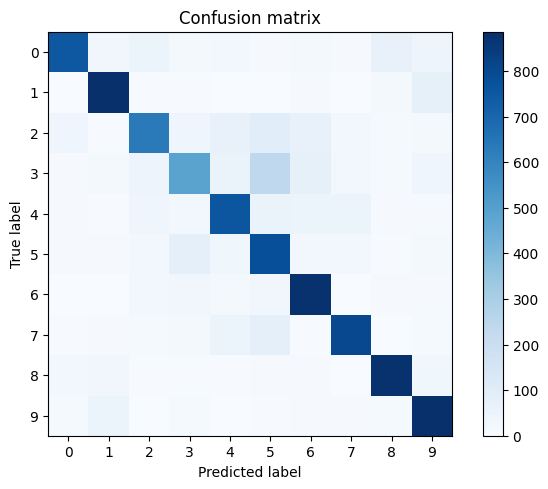

In [ ]:
result_confusion_matrix(cifar_model_alexnet)

In [ ]:
batch_normalization_history = []
batch_normalization_history_test = []
cifar_model_alexnet = create_alexnet(10, batch_normalization = True, dropout = True)
cifar_model_alexnet.compile(optimizer=SGD(learning_rate=best_learn_rate_for_accuracy),
              loss='categorical_crossentropy', metrics=['accuracy'])
batch_normalization_history.append(cifar_model_alexnet.fit(train_images, train_labels, batch_size=best_batch_size, epochs=best_epochs))
batch_normalization_history_test.append(cifar_model_alexnet.evaluate(test_images,  test_labels, batch_size=best_batch_size, verbose=5))


Epoch 1/30
391/391 [==============================] - 53s 122ms/step - loss: 1.8276 - accuracy: 0.3874
Epoch 2/30
391/391 [==============================] - 48s 122ms/step - loss: 1.3495 - accuracy: 0.5352
Epoch 3/30
391/391 [==============================] - 47s 119ms/step - loss: 1.1085 - accuracy: 0.6137
Epoch 4/30
391/391 [==============================] - 46s 118ms/step - loss: 0.9567 - accuracy: 0.6661
Epoch 5/30
391/391 [==============================] - 46s 119ms/step - loss: 0.8422 - accuracy: 0.7033
Epoch 6/30
391/391 [==============================] - 46s 118ms/step - loss: 0.7560 - accuracy: 0.7357
Epoch 7/30
391/391 [==============================] - 46s 118ms/step - loss: 0.6828 - accuracy: 0.7605
Epoch 8/30
391/391 [==============================] - 46s 118ms/step - loss: 0.6191 - accuracy: 0.7828
Epoch 9/30
391/391 [==============================] - 46s 118ms/step - loss: 0.5613 - accuracy: 0.8023
Epoch 10/30
391/391 [==============================] - 46s 118ms/step - l

313/313 [==============================] - 4s 12ms/step


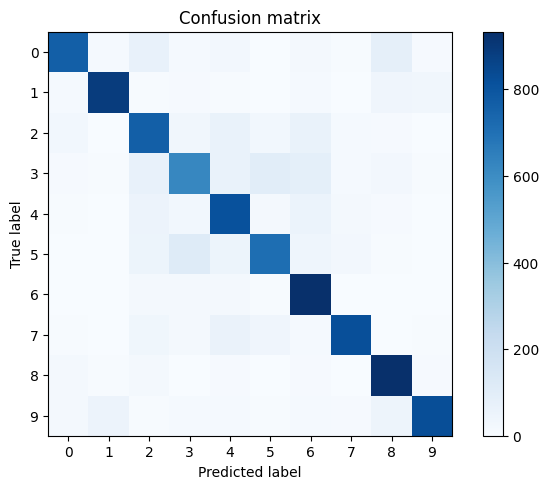

In [ ]:
result_confusion_matrix(cifar_model_alexnet)

In [ ]:
predictions = cifar_model_alexnet.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

class_metrics = classification_report(true_classes, predicted_classes)

313/313 [==============================] - 4s 12ms/step


In [ ]:
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Imprimir a matriz de confusão
print("Matriz de Confusão:")
print(confusion_mtx)

Matriz de Confusão:
[[765  13  71  13  23   1  18   6  81   9]
 [ 11 886   5   8   5   1  13   2  37  32]
 [ 27   2 762  30  65  28  62  13   8   3]
 [  9   4  72 623  63  99  87  13  23   7]
 [  6   1  53  29 815  15  57  16   8   0]
 [  3   2  48 115  51 710  42  22   7   0]
 [  1   1  19  20  17   6 933   0   3   0]
 [  6   0  35  20  61  39  11 821   2   5]
 [ 15   5  17   3   9   1   9   2 930   9]
 [ 19  54   7  12  11   5  14  10  44 824]]


In [ ]:
print("\nMétricas por classe:")
print(class_metrics)


Métricas por classe:
              precision    recall  f1-score   support

           0       0.89      0.77      0.82      1000
           1       0.92      0.89      0.90      1000
           2       0.70      0.76      0.73      1000
           3       0.71      0.62      0.67      1000
           4       0.73      0.81      0.77      1000
           5       0.78      0.71      0.75      1000
           6       0.75      0.93      0.83      1000
           7       0.91      0.82      0.86      1000
           8       0.81      0.93      0.87      1000
           9       0.93      0.82      0.87      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



# Testes Ciphar VGG16

## VGG16 Parte 1

In [ ]:
list_learn_rate = [1e-2,1e-3,1e-4]
list_batch_size = [128]
list_epochs = [5,10,15]

In [ ]:
learn_rate_history = []
learn_rate_history_test = []
for learn_rate in list_learn_rate:
  cifar_model_vgg16 = create_vgg16()
  cifar_model_vgg16.compile(optimizer=SGD(learning_rate=learn_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  learn_rate_history.append(cifar_model_vgg16.fit(train_images, train_labels, batch_size=128, epochs=10))
  learn_rate_history_test = cifar_model_vgg16.evaluate(test_images,  test_labels, batch_size=128, verbose=5)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


107/391 [=======>......................] - ETA: 8:05 - loss: 2.3020 - accuracy: 0.1190

In [ ]:
import matplotlib.pyplot as plt

for i in range (len(learn_rate_history)):
  plt.plot(learn_rate_history[i].history["loss"],label=f'loss: {list_learn_rate[i]}')
  plt.legend()



In [ ]:
for i in range (len(learn_rate_history)):
  plt.plot(learn_rate_history[i].history["accuracy"],label=f'accuracy: {list_learn_rate[i]}')
  plt.legend()

In [ ]:
accuracies = [history.history["accuracy"] for history in learn_rate_history]
best_accuracy_index = max(range(len(accuracies)), key=lambda i: accuracies[i][-1])
best_learn_rate_for_accuracy = list_learn_rate[best_accuracy_index]

print(f"Melhor taxa de aprendizado para a maior accuracy: {best_learn_rate_for_accuracy}")


In [ ]:
history_batchsize = []
history_test_batchsize = []
best_accuracy = 0
best_batch_size = None
contador = 0

for batch_size in list_batch_size:
  cifar_model_vgg16 = create_vgg16()
  cifar_model_vgg16.compile(optimizer=SGD(learning_rate=best_learn_rate_for_accuracy),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  history_batchsize.append(cifar_model_vgg16.fit(train_images, train_labels, batch_size=batch_size, epochs=20))
  history_test_batchsize.append(cifar_model_vgg16.evaluate(test_images,  test_labels, batch_size=batch_size, verbose=5))

  test_accuracy = history_test_batchsize[contador][1]

  contador = contador + 1
  if test_accuracy > best_accuracy:
      best_accuracy = test_accuracy
      best_batch_size = batch_size


In [ ]:
print(f"Melhor batchsize para a maior accuracy: {best_batch_size}")

## VGG 16 Parte 2

In [ ]:
best_learn_rate_for_accuracy = 0.01
best_batch_size = 128

In [ ]:
epochs_history = []
epochs_history_test = []

best_accuracy = 0
best_epochs = None
contador = 0

for epoch in list_epochs:
  cifar_model_vgg16 = create_vgg16(10)
  cifar_model_vgg16.compile(optimizer=SGD(learning_rate=best_learn_rate_for_accuracy),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  epochs_history.append(cifar_model_vgg16.fit(train_images, train_labels, batch_size=best_batch_size, epochs=epoch))
  epochs_history_test.append(cifar_model_vgg16.evaluate(test_images,  test_labels, batch_size=best_batch_size, verbose=5))

  test_accuracy = epochs_history_test[contador][1]

  contador = contador + 1

  if test_accuracy > best_accuracy:
    best_accuracy = test_accuracy
    best_epochs = epoch

Epoch 1/5


ResourceExhaustedError: ignored

In [ ]:
print(f"Melhor epoch para a maior accuracy: {best_epochs}")

In [ ]:
# Reshaping targets to match the TensorFlow's default shape for classification
train_labels = train_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)


# Converting labels from integers to one-hot vectors
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

def result_confusion_matrix(model):
  # Generating predictions for the test set
  y_pred = model.predict(test_images)
  y_pred = np.argmax(y_pred, axis=1)

  # Creating the confusion matrix
  y_test_label = np.argmax(test_labels, axis=1)
  cm = confusion_matrix(y_test_label, y_pred)

  # Displaying the confusion matrix
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(num_classes)
  plt.xticks(tick_marks, range(num_classes))
  plt.yticks(tick_marks, range(num_classes))
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:

cifar_model_vgg16 = create_vgg16(10, dropout = True)
cifar_model_vgg16.compile(optimizer=SGD(learning_rate=best_learn_rate_for_accuracy),
              loss='categorical_crossentropy', metrics=['accuracy'])
epochs_history.append(cifar_model_vgg16.fit(train_images, train_labels, batch_size=best_batch_size, epochs=best_epochs))
epochs_history_test.append(cifar_model_vgg16.evaluate(test_images,  test_labels, batch_size=best_batch_size, verbose=5))

result_confusion_matrix(cifar_model_vgg16)

In [ ]:
#device = cuda.get_current_device()
#device.reset()

## VGG 16 Parte 3

In [ ]:
best_learn_rate_for_accuracy = 0.01
best_batch_size = 128
best_epochs = 30

In [ ]:

gc.collect()
tf.keras.backend.clear_session()

cifar_model_vgg16 = create_vgg16(10, batch_normalization = True, dropout = True)
cifar_model_vgg16.compile(optimizer=SGD(learning_rate=best_learn_rate_for_accuracy),
              loss='categorical_crossentropy', metrics=['accuracy'])
epochs_history.append(cifar_model_vgg16.fit(train_images, train_labels, batch_size=best_batch_size, epochs=best_epochs))
epochs_history_test.append(cifar_model_vgg16.evaluate(test_images,  test_labels, batch_size=best_batch_size, verbose=5))

result_confusion_matrix()

In [ ]:
result_confusion_matrix()

In [ ]:
predictions = cifar_model_alexnet.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

class_metrics = classification_report(true_classes, predicted_classes)

In [ ]:
print("\nMétricas por classe:")
print(class_metrics)